# Boilerplate setup

In [34]:
# Getting the dataset from the github repo of imagenet 5 categories
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


# Importing packages

In [35]:
import requests
import zipfile
import io

In [36]:
r = requests.get('https://github.com/thunderInfy/resnet-simclr/blob/master/results.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()  

In [37]:
import numpy as np
import torch
from torchvision import transforms as T
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

import os
from PIL import Image
from collections import OrderedDict

import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

# From the cloned directory, loading training and test dataset - Imagenet Dataset (5 Categories)

In [38]:
# device is set to cuda if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# root folder is the name of the folder where data is contained
root_folder = 'imagenet-5-categories'

train_names = sorted(os.listdir(root_folder + '/train'))
test_names = sorted(os.listdir(root_folder + '/test'))

# setting random seed to ensure the same 10% labelled data is used when training the linear classifier
random.seed(0)

names_train_10_percent = random.sample(train_names, len(train_names) // 10)
names_train = random.sample(train_names, len(train_names))
names_test = random.sample(test_names, len(test_names))

# Encoding the labels to numerical values

# Labels are extracted from the image names to help in visualizing the results

# The 10% of the training dataset is used for the linear classifier learning, to understand the performance of the representation learnt from the Simclr 

In [39]:
# Assigning numerical values to the categories
mapping = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
inverse_mapping = ['car', 'dog', 'elephant', 'cat', 'airplane']

# Finding the label for each image and storing them in variables for visualization purpose
labels_train = [mapping[x.split('_')[0]] for x in names_train]
labels_test = [mapping[x.split('_')[0]] for x in names_test]

# Taking the 10% of the training dataset for later use
labels_train_10_percent = [mapping[x.split('_')[0]] for x in names_train_10_percent]

# Applies color jitter and gray_scale randomly on images 

In [40]:
def get_color_distortion(s=1.0):
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.7)
    

    rnd_gray = T.RandomGrayscale(p=0.3)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    
    return color_distort

# Dataset class defined to rescale, apply mutation & tensorify the input images 

In [41]:
class MyDataset(Dataset):
    def __init__(self, root_dir, filenames, labels, mutation=False):
        self.root_dir = root_dir
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = get_color_distortion(1)(res)
        return res

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name)
        label = self.labels[idx]
        image = T.Resize((250, 250))(image)

        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2, 'label': label}
        else:
            image = T.Resize((224, 224))(image)
            image = self.tensorify(image)
            sample = {'image': image, 'label': label}

        return sample

# Applying the Dataset class definition on the input dataset

In [42]:
training_dataset_mutated = MyDataset(root_folder + '/train', names_train, labels_train, mutation=True)
training_dataset = MyDataset(root_folder + '/train', names_train_10_percent, labels_train_10_percent, mutation=False)
testing_dataset = MyDataset(root_folder + '/test', names_test, labels_test, mutation=False)

# Applied Dataloader with batch_size = 16 on the input dataset to avoid the memory issue 

In [43]:
dataloader_training_dataset_mutated = DataLoader(training_dataset_mutated, batch_size=16, shuffle=True, num_workers=2)
dataloader_training_dataset = DataLoader(training_dataset, batch_size=16, shuffle=True, num_workers=2)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=16, shuffle=True, num_workers=2)

# Loaded RESNET-18 architecture without the fully connected neural network layer 


# Replaced the existing fully connected layer with three layers and manually defined the following fc layers

# First Layer - Takes the output of encoding features of RESNET architecture & outputs 100 neurons, followed by ReLU activation function <br>
# Second Layer - Takes 100 features as input and outputs 50 neurons, followed by ReLU activation function <br>
# Third Layer - Takes 50 features as input and outputs 25 neurons

In [44]:

resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnet.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))

resnet.fc = classifier

In [45]:
import gc
gc.collect()

57442

# Printed the summary of the architecture built

In [46]:
resnet.to(device)
torch.cuda.empty_cache()
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Printing the memory status

In [47]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  531616 KB |  596078 KB |   21417 GB |   21417 GB |\n|       from large pool |  503104 KB |  561952 KB |   21103 GB |   21103 GB |\n|       from small pool |   28512 KB |   48490 KB |     313 GB |     313 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  531616 KB |  596078 KB |   21417 GB |   21417 GB |\n|       from large pool |  503104 KB |  561952 KB |

# Defined the loss function for Simclr training with temperature hyperparameter as 0.04

In [48]:

tau = 0.04

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

# Defining optimizer and creating directory for results

In [49]:


losses_train = []
num_epochs = 10

# using SGD optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists('results'):
    os.makedirs('results')



# Set training as TRUE and initiated the training in small batch_size of 16.<br> <br> 
#The two variations of single image are passed as input to loss function to generate representations that have higher cosine similarity for those two variation images and have lower cosine similarity between each of the variation image and other images in the dataset.

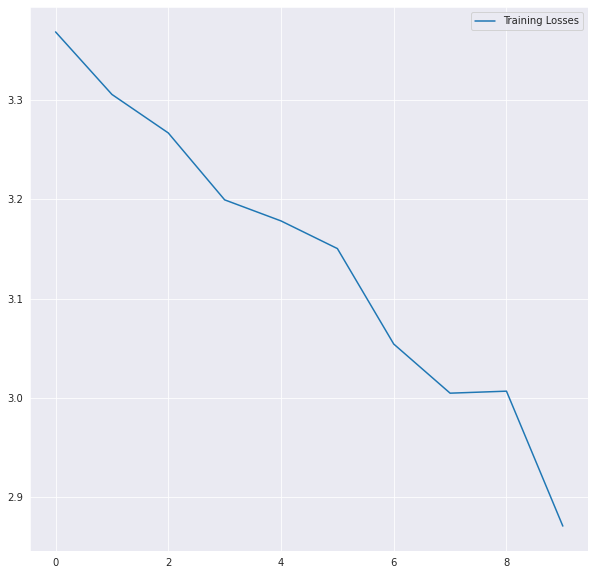

In [50]:


TRAINING = True

def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
    # get resnet in train mode
    resnet.train()
        
    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []

        # run a for loop for each batch
        for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):
            # print(len(sample_batched['image1']))
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']
            resnet.to(device)
            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = resnet(x1)
            y2 = resnet(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))        

        # Store model and optimizer files
        torch.save(resnet.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(losses_train))

fig = plt.figure(figsize=(10, 10))
sns.set_style('darkgrid')
plt.plot(losses_train)
plt.legend(['Training Losses'])
plt.savefig('losses.png')

# Once trained the last layers are removed sequentially until the projection head is completed removed and plot t-SNE visualization 

In [51]:
import warnings
warnings.filterwarnings('ignore')

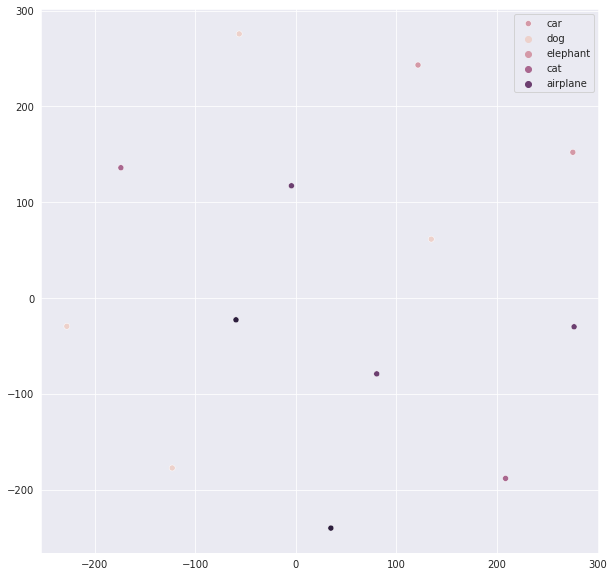

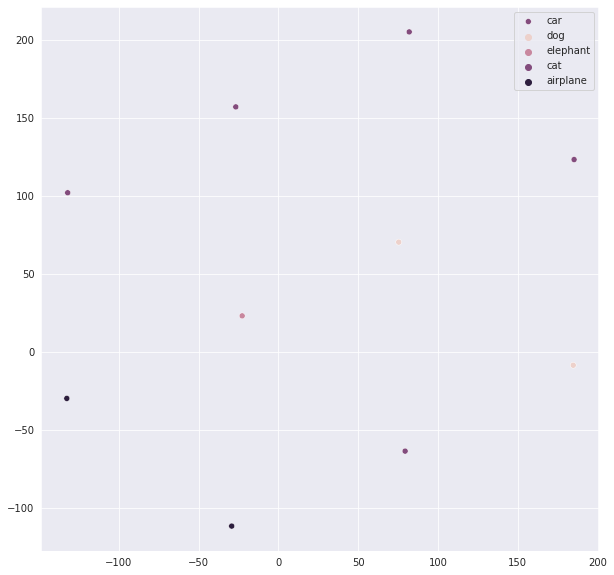

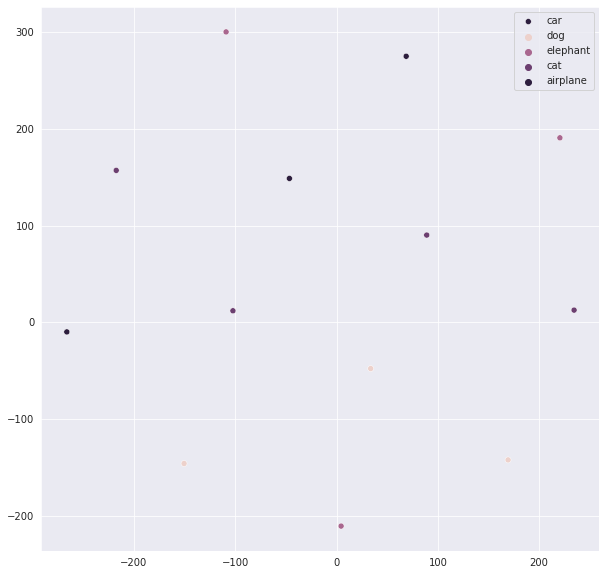

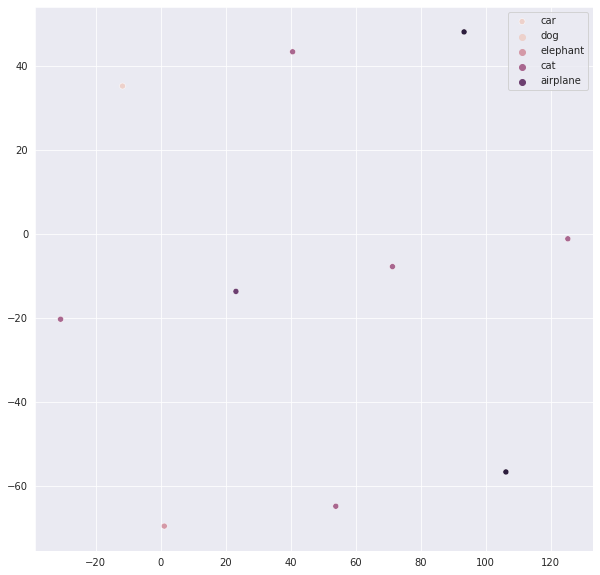

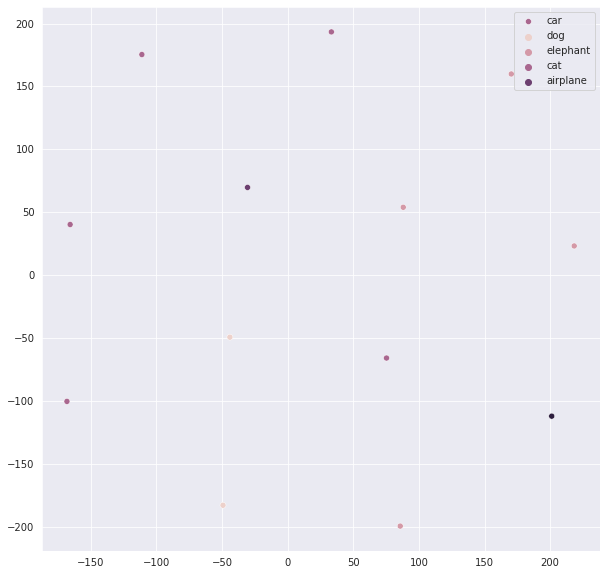

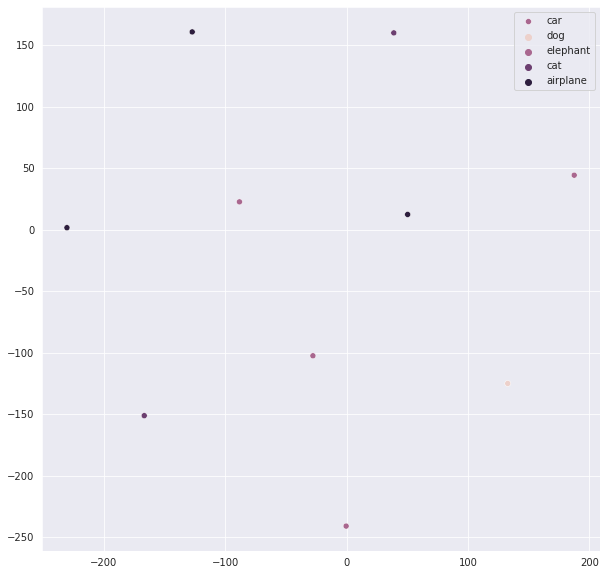

In [52]:
# a function used to plot t-SNE visualizations
def plot_vecs_n_labels_show(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    # plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full',edgecolors='b')
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.show()
    plt.close()

def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full')
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.savefig(fname)
    plt.close()

# Boolean variable to control whether to perform t-SNE visualization or not
TSNEVIS = True

if TSNEVIS:
    # run resnet in eval mode
    resnet.eval()

    # get TSNE visualizations of 10% training dataset
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')
        y_temp_tsne=y_tsne
        x = None
        y = None
        y_tsne = None
        sample_batched = None
    plot_vecs_n_labels_show(y_temp_tsne,labels,'tsne_train_last_layer.png')
    # get TSNE visualizations of testing dataset
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_last_layer.png')
        y_temp_tsne=y_tsne
        x = None
        y = None
        y_tsne = None
        sample_batched = None
    plot_vecs_n_labels_show(y_temp_tsne,labels,'tsne_train_last_layer.png')
# Removing the last layer and the relu layer, we remove layers incrementally and look t-SNE visualizations
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_second_last_layer.png')
        y_temp_tsne=y_tsne
        x = None
        y = None
        y_tsne = None
        sample_batched = None
    plot_vecs_n_labels_show(y_temp_tsne,labels,'tsne_train_second_last_layer.png')
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_second_last_layer.png')
        y_temp_tsne=y_tsne
        x = None
        y = None
        y_tsne = None
        sample_batched = None
    plot_vecs_n_labels_show(y_temp_tsne,labels,'tsne_test_second_last_layer.png') 
# removing one more layer, our entire projection head will be removed after this
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_train.png')
        y_temp_tsne=y_tsne
        x = None
        y = None
        y_tsne = None
        sample_batched = None
    plot_vecs_n_labels_show(y_temp_tsne,labels,'tsne_hidden_train.png')
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_test.png')
        y_temp_tsne=y_tsne
        x = None
        y = None
        y_tsne = None
        sample_batched = None
    plot_vecs_n_labels_show(y_temp_tsne,labels,'tsne_hidden_test.png')    

# Set Linear as TRUE and use the trained Simclr representation as input to linear classifier to see how good the innate nature of each image is clearly captured

In [53]:
# Boolean variable to control whether to train the linear classifier or not
LINEAR = True

class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = torch.nn.Linear(100, 5)

    def forward(self, x):
        x = self.fc1(x)
        return(x)

if LINEAR:

    if not os.path.exists('linear'):
        os.makedirs('linear')

    # getting our linear classifier
    linear_classifier = LinearNet()

    # moving it to device
    linear_classifier.to(device)

    # using SGD as a linear optimizer
    linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

    #number of epochs
    num_epochs_linear = 10

    # Boolean variable to control training of linear classifier
    LINEAR_TRAINING = True

    # Defining data structures to store train and test info for linear classifier
    losses_train_linear = []
    acc_train_linear = []
    losses_test_linear = []
    acc_test_linear = []

    # a variable to keep track of the maximum test accuracy, will be useful to store 
    # model parameters with the best test accuracy
    max_test_acc = 0

    # if a model exists in the linear folder, load it
    if(os.path.isfile("linear/model.pth")):

        # load state dict for linear model and optimizer
        linear_classifier.load_state_dict(torch.load("linear/model.pth"))
        linear_optimizer.load_state_dict(torch.load("linear/optimizer.pth"))

        # change learning rate, you can change its values if you don't feel its necessity while training
        for g in linear_optimizer.param_groups:
          g['lr'] = 0.001
          g['weight_decay'] = 0

        # load data structures
        temp = np.load("linear/linear_losses_train_file.npz")
        losses_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_losses_test_file.npz")
        losses_test_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_train_file.npz")
        acc_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_test_file.npz")
        acc_test_linear = list(temp['arr_0'])

    # Run a for loop for training the linear classifier
    for epoch in range(num_epochs_linear):

        if LINEAR_TRAINING:

            # run linear classifier in train mode
            linear_classifier.train()

            # a list to store losses for each batch in an epoch
            epoch_losses_train_linear = []
            epoch_acc_train_num_linear = 0.0
            epoch_acc_train_den_linear = 0.0

            # for loop for running through each batch
            for (_, sample_batched) in enumerate(dataloader_training_dataset):

                # get x and y from the batch
                x = sample_batched['image']
                y_actual = sample_batched['label']

                # move them to the device
                x = x.to(device)
                y_actual  = y_actual.to(device)

                # get output from resnet architecture
                y_intermediate = resnet(x)

                # zero the grad values
                linear_optimizer.zero_grad()

                # run y_intermediate through the linear classifier
                y_predicted = linear_classifier(y_intermediate)

                # get the cross entropy loss value
                loss = nn.CrossEntropyLoss()(y_predicted, y_actual)

                # add the obtained loss value to this list
                epoch_losses_train_linear.append(loss.data.item())
                
                # perform backprop through the loss value
                loss.backward()

                # call the linear_optimizer step function
                linear_optimizer.step()

                # get predictions and actual values to cpu  
                pred = np.argmax(y_predicted.cpu().data, axis=1)
                actual = y_actual.cpu().data

                #update the numerators and denominators of accuracy
                epoch_acc_train_num_linear += (actual == pred).sum().item()
                epoch_acc_train_den_linear += len(actual)

                x = None
                y_intermediate = None
                y_predicted = None
                sample_batched = None

            # update losses and acc lists    
            losses_train_linear.append(get_mean_of_list(epoch_losses_train_linear))
            acc_train_linear.append(epoch_acc_train_num_linear / epoch_acc_train_den_linear)
        
        # run linear classifier in eval mode
        linear_classifier.eval()

        # essential variables to keep track of losses and acc
        epoch_losses_test_linear = []
        epoch_acc_test_num_linear = 0.0
        epoch_acc_test_den_linear = 0.0

        # run a for loop through each batch
        for (_, sample_batched) in enumerate(dataloader_testing_dataset):
            x = sample_batched['image']
            y_actual = sample_batched['label']

            x = x.to(device)
            y_actual  = y_actual.to(device)

            y_intermediate = resnet(x)

            y_predicted = linear_classifier(y_intermediate)
            loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
            epoch_losses_test_linear.append(loss.data.item())

            pred = np.argmax(y_predicted.cpu().data, axis=1)
            actual = y_actual.cpu().data
            epoch_acc_test_num_linear += (actual == pred).sum().item()
            epoch_acc_test_den_linear += len(actual)

        # calculate test_acc
        test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
        print(test_acc)

        if LINEAR_TRAINING:
            losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
            acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

            # plotting losses and accuracies

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(losses_train_linear)
            plt.plot(losses_test_linear)
            plt.legend(['Training Losses', 'Testing Losses'])
            plt.savefig('linear/losses.png')
            plt.close()

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(acc_train_linear)
            plt.plot(acc_test_linear)
            plt.legend(['Training Accuracy', 'Testing Accuracy'])
            plt.savefig('linear/accuracy.png')
            plt.close()

            print("Epoch completed")

            if test_acc >= max_test_acc:

                # save the model only when test_acc exceeds the current max_test_acc

                max_test_acc = test_acc
                torch.save(linear_classifier.state_dict(), 'linear/model.pth')
                torch.save(linear_optimizer.state_dict(), 'linear/optimizer.pth')

        # save data structures
        np.savez("linear/linear_losses_train_file", np.array(losses_train_linear))
        np.savez("linear/linear_losses_test_file", np.array(losses_test_linear))
        np.savez("linear/linear_acc_train_file", np.array(acc_train_linear))
        np.savez("linear/linear_acc_test_file", np.array(acc_test_linear))

# Afunction to get PIL image from tensor

# def deprocess_and_show(img_tensor):
#     return T.Compose([
#             T.Normalize((0, 0, 0), (2, 2, 2)),
#             T.Normalize((-0.5, -0.5, -0.5), (1, 1, 1)),
#             T.ToPILImage()
#           ])(img_tensor)




0.2
Epoch completed
0.2
Epoch completed
0.2
Epoch completed
0.176
Epoch completed
0.12
Epoch completed
0.148
Epoch completed
0.164
Epoch completed
0.192
Epoch completed
0.212
Epoch completed
0.216
Epoch completed


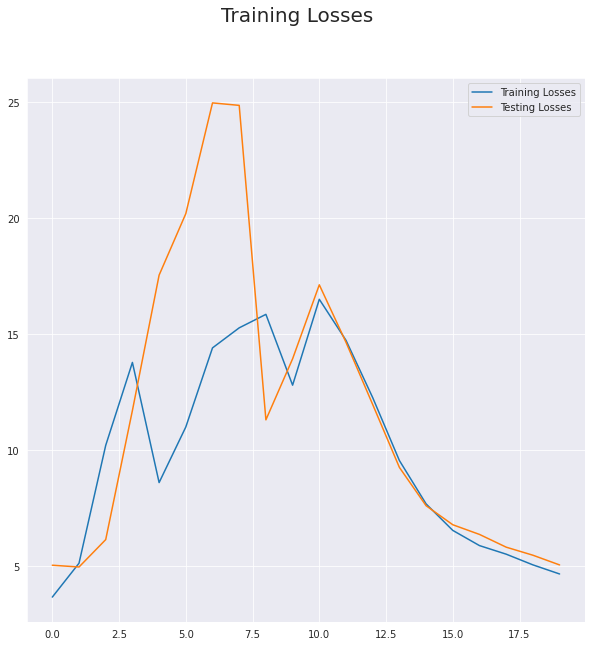

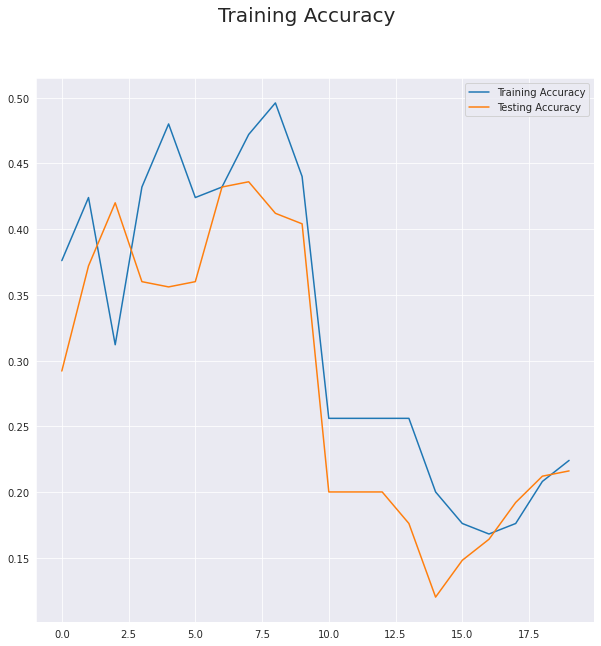

In [62]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Training Losses', fontsize=20)
sns.set_style('darkgrid')
plt.plot(losses_train_linear)
plt.plot(losses_test_linear)
plt.legend(['Training Losses', 'Testing Losses'])
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Training Accuracy', fontsize=20)
sns.set_style('darkgrid')
plt.plot(acc_train_linear)
plt.plot(acc_test_linear)
plt.legend(['Training Accuracy', 'Testing Accuracy'])
plt.show()
plt.close()